# Setup (imports, constants, etc.)

See scikit-learn [FAQ][1] for multiprocessing issue info fixed below:

[1]:http://scikit-learn.org/stable/faq.html#why-do-i-sometime-get-a-crash-freeze-with-n-jobs-1-under-osx-or-linux

In [1]:
import multiprocessing

start_method = 'forkserver'
try:
    multiprocessing.set_start_method(start_method)
except RuntimeError as e:
    if str(e) != 'context has already been set':
        raise e
    elif multiprocessing.get_start_method() != start_method:
        raise RuntimeWarning(
            'Multiprocessing start_method {} was not set.'
            .format(start_method)
        )
        
N_JOBS = -1  # for sklearn

In [2]:
import glob
import multiprocessing
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from eda_plots import (ConditionalProbabilities,
                       plot_count_comparison, plot_interest_pie)
from main import dump_pickle, read_rental_interest
from outlier_detection import (drop_geo_outl, drop_price_outl, is_geo_outl,
                               is_price_outl)
from preprocessing import LatLongImputer, exp_int, get_word_cnt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, make_scorer

%matplotlib inline

# Autoreload all imported modules at each execution.
%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.4f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
REPORT_IMG_DIR = '../Report-Images/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

# Using built-in 'neg_log_loss' scoring param used for simplicity
# Source code shows exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(TRAIN_FP)
df_te = read_rental_interest(TEST_FP)

if DF_TRAIN_PKL not in glob.glob(DAT_DIR+'*'):
    dump_pickle(df, DF_TRAIN_PKL)
if DF_TEST_PKL not in glob.glob(DAT_DIR+'*'):
    dump_pickle(df_te, DF_TEST_PKL)

/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Exploratory Data Analysis

## Train vs test data

Are datasets random samples from same source?

In [40]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df.shape, df_te.shape

((49352, 14), (74659, 13))

Kolmogorov-Smirnov p-value: 0.998
Show sampled same distribution very likely


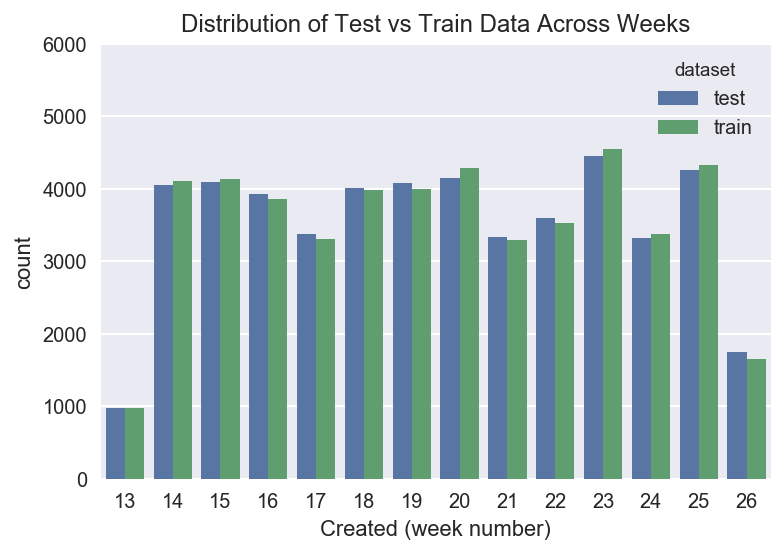

In [33]:
# Same size for easier comparisons
df_te_sized = df_te.sample(n=len(df), random_state=SEED)
ax = plot_count_comparison(
    x='week',
    df_tr=df.assign(week=df.created.dt.week),
    df_te=df_te_sized.assign(week=df_te_sized.created.dt.week)
)

plt.ylim(0, 6000)
plt.xlabel('Created (week number)')
plt.title('Distribution of Test vs Train Data Across Weeks')

_, ks2_pval = stats.ks_2samp(df_te.created.dt.week, df.created.dt.week)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

Kolmogorov-Smirnov p-value: 0.940
Show sampled same distribution very likely


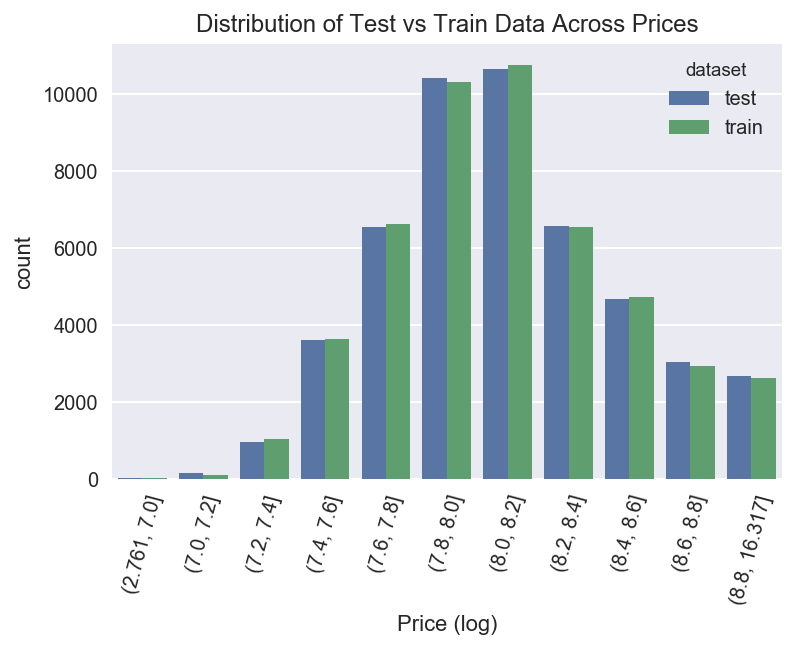

In [35]:
df_te_sized = df_te.sample(n=len(df), random_state=SEED)

min_ = np.log(df.price.min()) - 1
max_ = np.log(df.price.max()) + 1
bins = [min_, 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6, 8.8, max_]

data_tr = df.assign(price_lg=pd.cut(np.log(df.price), bins))
data_te = df_te_sized.assign(price_lg=pd.cut(np.log(df_te_sized.price), bins))

ax = plot_count_comparison(x='price_lg', df_tr=data_tr, df_te=data_te)

plt.xticks(rotation=75)
plt.xlabel('Price (log)')
plt.title('Distribution of Test vs Train Data Across Prices')

_, ks2_pval = stats.ks_2samp(df_te_sized.price, df.price)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

In [37]:
print('***Kolmogorov-Smirnov p-values***')
for name in df.drop('interest_level', axis=1).select_dtypes([int, float]).columns:
    _, ks2_pval = stats.ks_2samp(df[name], df_te_sized[name])
    print('{:<10}: {:>5.3f}'.format(name, ks2_pval))

***Kolmogorov-Smirnov p-values***
bathrooms : 0.995
bedrooms  : 0.998
latitude  : 0.231
longitude : 0.747
price     : 0.940


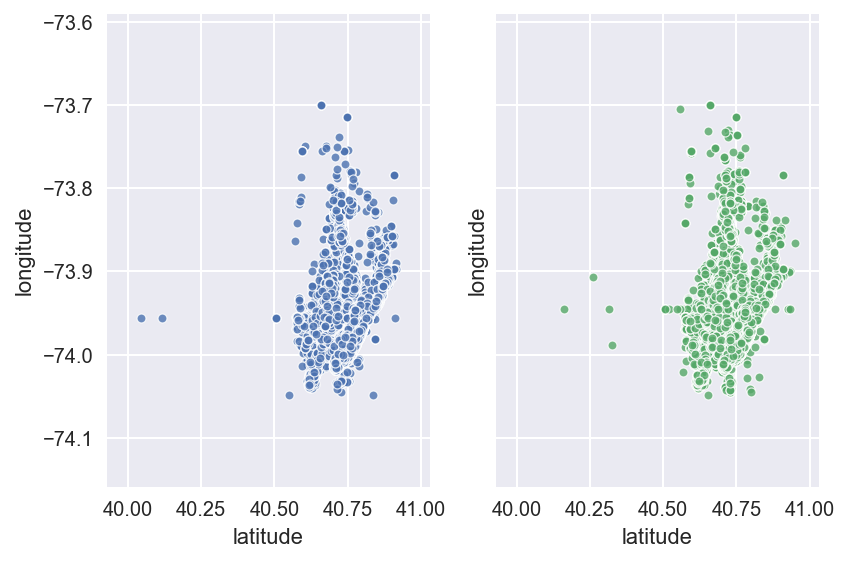

In [41]:
df1 = LatLongImputer(broad=True).fit_transform(df).assign(dataset='train')
df2 = LatLongImputer(broad=True).fit_transform(df_te).assign(dataset='test')

data = pd.concat([df1, df2])

fig, (ax1, ax2) = plt.subplots(ncols=2,
                               sharex=True, sharey=True)

with sns.axes_style('white'):
    for ax, df_ in ((ax1, df1), (ax2, df2)):
        sns.regplot(x='latitude', y='longitude', data=df_, fit_reg=False,
                    ax=ax, scatter_kws=dict(edgecolor='w', lw=.6, s=20)
    )

plt.tight_layout()

In [43]:
tr_cnts = df.manager_id.value_counts()
te_cnts = df_te.manager_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of managers in both datasets'.format(n_in_both/len(merged)))

tr_cnts = df.building_id.value_counts()
te_cnts = df_te.building_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of buildings in both datasets'.format(n_in_both/len(merged)))

67% of managers in both datasets
45% of buildings in both datasets


## Are there any rentals listed twice?

In [4]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df_all = pd.concat([df.drop('interest_level', axis=1), df_te])
df_all.shape

(124011, 13)

In [5]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id', 'manager_id']
is_dupe = df.duplicated(subset, keep=False)
df[is_dupe].sort_values(subset).T

listing_id,6842689,7112955,6834172,6872105,7162560,7028603,6921691,7032828,6978996,7002150,...,7074029,7232801,6989183,6999811,7006884,7017467,6895545,7216315,7093306,7159729
bathrooms,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,5.0000,5.0000,2.0000,2.0000,2.0000,2.0000,3.0000,3.0000,4.0000,4.0000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,5,5,6,6,6,6,6,6,6,6
building_id,acf04eb24372da8ce23a7f73c3b099da,acf04eb24372da8ce23a7f73c3b099da,d8b20f7bd163403c49d242d50607cc0d,d8b20f7bd163403c49d242d50607cc0d,70093585319d049535fdc64e4f387da3,70093585319d049535fdc64e4f387da3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,...,4c82773ff23782a525c36ff0699cb153,4c82773ff23782a525c36ff0699cb153,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,0,0,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab
created,2016-04-08 02:56:02,2016-06-05 02:53:45,2016-04-06 08:04:51,2016-04-14 04:09:51,2016-06-15 03:00:25,2016-05-18 02:57:34,2016-04-25 02:34:07,2016-05-18 07:22:52,2016-05-07 03:14:38,2016-05-12 05:40:54,...,2016-05-27 02:33:39,2016-06-29 06:13:27,2016-05-10 03:15:08,2016-05-12 02:43:54,2016-05-13 04:56:06,2016-05-15 05:52:33,2016-04-19 05:40:00,2016-06-25 05:28:36,2016-06-01 06:07:31,2016-06-14 15:42:54
description,Spacious studio at Sullivan Mews.Sullivan Mews...,Spacious studio at Sullivan Mews--available la...,Studio on Upper West Side,Studio on Upper West Side,"90 West Street is a beautiful pre-war, full se...","90 West Street is a beautiful pre-war, full se...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...",...,Magnificent 5 bedroom / 5 bathroom duplex pent...,Magnificent 5 bedroom / 5 bathroom duplex pent...,This beautiful 6 bedroom apartment is brand ne...,This beautiful 6 bedroom apartment is brand ne...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,"NO FEE!!!, Fantastic for sharing, bright 6 Bed...","Bright, Perfect for Sharing 6 Bedroom / 3 Bath...","Unique and rare 6 bedroom, 4 bath apartment wi...","Unique and rare 6 bedroom, 4 bath apartment wi..."
display_address,115 Sullivan Street,115 Sullivan Street,W 87th St,W 87th St,90 West Street,90 West Street,East 82nd Street,East 82nd Street,East 82nd Street,East 82nd Street,...,East 94th Street,East 94th Street,W 107 St.,W 107 St.,311 Broadway,311 Broadway,West 107th Street,West 107th Street,E 70th St,E 70th St
features,"[No Fee, Exclusive, Elevator]","[No Fee, Exclusive, Elevator]",[Elevator],[Elevator],"[Fitness Center, Residents Lounge, On-site Gar...","[Fitness Center, Residents Lounge, On-site Gar...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...",...,"[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Pre-War, Laundry in Building, Dogs Allowed, C...","[Pre-War, Laundry in Building, No Fee, Dogs Al...","[Elevator, Laundry in Building, Dishwasher, Ha...","[Elevator, Laundry in Building, Dishwasher, Ha..."
interest_level,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,2,1,1,1
latitude,40.7260,40.7260,40.7894,40.7894,40.7100,40.7100,40.7760,40.7760,40.7760,40.7760,...,40.7826,40.7826,40.8015,40.8015,40.7157,40.7157,40.8015,40.8015,40.7676,40.7676
longitude,-74.0026,-74.0026,-73.9764,-73.9764,-74.0143,-74.0143,-73.9556,-73.9556,-73.9556,-73.9556,...,-73.9469,-73.9469,-73.966

In [6]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id']
is_dupe = df_all.duplicated(subset, keep=False)
df_all[is_dupe].sort_values(subset).T

listing_id,7005340,7010798,6978506,6851809,7153326,6835131,6979910,6834974,6936950,6877851,...,6823981,7122976,7059766,6943719,6983545,6937105,7110293,7061389,6878604,6926894
bathrooms,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,5.5000,5.5000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,7,7
building_id,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,d7b647fc80f992a06381b7f636dad338,d7b647fc80f992a06381b7f636dad338,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,4559c07c932505a2e570a8c25f8465b6,...,87c4e08083ac83618dd9fdbf849331fe,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab,0,0,0,8d83f6be6675419b19a6fc29a6ce6cee,8d83f6be6675419b19a6fc29a6ce6cee,2094beb4097c7f56670afba5b01b31a4,2094beb4097c7f56670afba5b01b31a4
created,2016-05-13 02:59:48,2016-05-14 03:01:53,2016-05-07 02:54:26,2016-04-10 02:49:58,2016-06-12 14:22:12,2016-04-06 18:12:38,2016-05-07 04:05:12,2016-04-06 18:05:35,2016-04-28 04:03:45,2016-04-15 04:59:14,...,2016-04-05 02:55:00,2016-06-08 02:10:53,2016-05-24 04:07:11,2016-04-29 06:30:33,2016-05-08 04:16:51,2016-04-28 04:14:55,2016-06-04 05:34:54,2016-05-24 05:59:12,2016-04-15 05:50:47,2016-04-26 05:37:31
description,Beautiful Studio with On Site Garage and Fitne...,In the heart of Brooklyn is a collection of in...,Fantastic Studio with On Site Garage and Fitne...,Gorgeous Studio with On Site Garage and Fitnes...,,,,,,,...,Rent listed is net effective after one month f...,"Apartment features king size six bedroom, four...",,Queen Size BedroomsEbony Hardwood FloorsRecess...,Nothing like this on the Upper East Side and 7...,Nothing like this on the Upper East Side and 7...,"This is a Brand New, Gut Renovated Large 6 Bed...","**NO FEE**This is a Brand New, Gut Renovated L...",SPECTACULAR PENTHOUSE IN THE SKY ! 5 bedroom /...,"GRAND ENTRANCE: FRAMED WITH LIMESTONE PIERS, O..."
display_address,1403 New York Avenue,1403 New York Ave.,1403 New York Avenue,1403 New York Avenue,Clarendon Rd,Clarendon Rd,Broadway,Broadway,Broadway,Grand Central Parkway West,...,E 77 St.,"E 70th St,",East 70th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street\r,East 39th Street,East 39th Street
features,"[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...",[],[],"[Elevator, No Fee]",[Elevator],"[Elevator, No Fee]",[],...,"[Pre-War, Laundry in Unit, Dishwasher, Hardwoo...","[private-outdoor-space, balcony, Elevator, Sta...","[Doorman, Elevator, Cats Allowed, Dogs Allowed]","[Laundry in Unit, Dishwasher, Hardwood Floors,...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Pre-War, Laundry in Unit, Hardwood Floors, No...","[Dining Room, Pre-War, Laundry in Unit, Dishwa...","[Fireplace, Swimming Pool, Roof Deck, Dining R...","[Swimming Pool, Roof Deck, Dining Room, Balcon..."
latitude,40.6386,40.6386,40.6386,40.6386,40.6435,40.6435,40.8198,40.8198,40.8198,40.7196,...,40.7716,40.7676,40.7676,40.7701,40.7701,40.7701,40.7701,40.7701,40.7479,40.7479
longitude,-73.9450,-73.9450,-73.9450,-73.9450,-73.9428,-73.9428,-73.9578,-73.9578,-73.9578,-73.8351,...,-73.9544,-73.9601,-73.9601,-73.9550,-73.9550,-73.9550,-73.9550,-73.9550,-73.9746,-73.9746
manager_id,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9556a2e6dd5f856dfaf77cd09fb8af38,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,e6472c7237327dd3903b3d6f6a94515a,...,e6472c7237327dd3903b3d6f6a94515a,d736fef906de04d74830e913b1c91b5a,8f5a9c893f6d602f4953f

In [7]:
data = df_all

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6827050,7485494,7121825,6834448,7121804,6840762,7670925,6862495,6862503,7206163,...,7025421,7025420,7025763,7025764,7025922,7025923,7025164,7025163,7186031,7186030
bathrooms,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,2.5000,2.5000,3.0000,3.0000,3.0000,3.0000,3.5000,3.5000,4.5000,4.5000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,4,4,4,4
building_id,0,0,0,0,0,0,0,0,0,0,...,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1,1f08a2db498242410566a351799b12f0,1f08a2db498242410566a351799b12f0,5946e4ecda0d333735c2b04b5f4ec2e0,5946e4ecda0d333735c2b04b5f4ec2e0,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,3471bc324ab99b92a5b56763d25c8cf3,3471bc324ab99b92a5b56763d25c8cf3
created,2016-04-05 12:44:57,2016-04-05 12:44:57,2016-04-06 12:54:03,2016-04-06 12:54:03,2016-04-07 14:40:14,2016-04-07 14:40:14,2016-04-12 11:50:05,2016-04-12 11:50:05,2016-04-12 12:02:03,2016-04-12 12:02:03,...,2016-05-17 14:29:08,2016-05-17 14:29:08,2016-05-17 14:38:04,2016-05-17 14:38:04,2016-05-17 14:41:01,2016-05-17 14:41:01,2016-05-17 14:24:29,2016-05-17 14:24:29,2016-06-20 19:12:33,2016-06-20 19:12:33
description,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,This studio apartment has been newly renovated...,This studio apartment has been newly renovated...,This spacious studio apartment is right in the...,This spacious studio apartment is right in the...,- Beautiful Studio- Brand New Kitchen Applianc...,- Beautiful Studio- Brand New Kitchen Applianc...,Renovated studio apartment has new kitchen and...,Renovated studio apartment has new kitchen and...,...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...,Massive renovated 3 bedroom in a PreWar buildi...,Massive renovated 3 bedroom in a PreWar buildi...,"This is a Brand New, Gut Renovated 3 Bedroom D...","This is a Brand New, Gut Renovated 3 Bedroom D...",Large converted 4 BR/3.5 BA home w/ panoramic ...,Large converted 4 BR/3.5 BA home w/ panoramic ...,Sprawling floor-thru Penthouse unit located in...,Sprawling floor-thru Penthouse unit located in...
display_address,West Street,West Street,John St,John St,Wall St,Wall St,E 61 st,E 61 st,South End Avenue,South End Avenue,...,E 70th St.,E 70th St.,E 72nd St.,E 72nd St.,E 81 St.,E 81 St.,East 56th Street,East 56th Street,E 57 St.,E 57 St.
features,"[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...",...,"[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Balcony, Doorman, Elevator, Terrace, Laundry ...","[Balcony, Doorman, Elevator, Terrace, Laundry ..."
latitude,40.7053,40.7053,40.7076,40.7076,40.7033,40.7033,40.7627,40.7627,40.7158,40.7158,...,40.7679,40.7679,40.7688,40.7688,40.7739,40.7739,40.7579,40.7579,40.7582,40.7582
longitude,-74.0114,-74.0114,-74.0105,-74.0105,-74.0140,-74.0140,-73.9690,-73.9690,-74.0156,-74.0156,...,-73.9598,-73.9598,-73.9592,-73.9592,-73.9529,-73.9529,-73.9653,-73.9653,-73.9634,-73.9634
manager_id,3734dac511776b0990e90a94d71c8251,3734dac511776b0990e90a94d71c8251,d12f4c3b61d726c5b7f74ffda19ad9ce,d12f4c3b61d726c5b7f74ffda19ad9ce,d12f4c3b61d726c5b

In [8]:
data = df.drop('interest_level', axis=1)

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6868769,7222580,7547579,7133023,7485458,7023521,7025062,7025061,7155593,6822458,...,7056185,6956382,7056191,6956411,7019955,7567437,7025646,7025645,7025421,7025420
bathrooms,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.5000,2.5000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,2,2,3,3,3,3,3,3,3,3
building_id,0,0,0,0,c94301249b8c09429d329864d58e5b82,c94301249b8c09429d329864d58e5b82,d16f875956b264d5920d8424631091d4,d16f875956b264d5920d8424631091d4,fcd0bca4ee9c7bd444dbba39e8caa4fe,fcd0bca4ee9c7bd444dbba39e8caa4fe,...,f5e2cdb7a92059ee5e3dbd97b03f03ce,f5e2cdb7a92059ee5e3dbd97b03f03ce,315a2f868a195b076e5be73411110da2,315a2f868a195b076e5be73411110da2,d0234abbc01a982d54e8d446acc03405,d0234abbc01a982d54e8d446acc03405,dd7b281c0dbafc8b53575ab78cca75d4,dd7b281c0dbafc8b53575ab78cca75d4,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1
created,2016-04-13 12:53:40,2016-04-13 12:53:40,2016-06-09 18:48:01,2016-06-09 18:48:01,2016-05-17 11:16:30,2016-05-17 11:16:30,2016-05-17 14:21:48,2016-05-17 14:21:48,2016-04-04 18:44:53,2016-04-04 18:44:53,...,2016-05-03 02:57:23,2016-05-03 02:57:23,2016-05-03 02:58:11,2016-05-03 02:58:11,2016-05-16 12:49:47,2016-05-16 12:49:47,2016-05-17 14:35:36,2016-05-17 14:35:36,2016-05-17 14:29:08,2016-05-17 14:29:08
description,"Spacious studio with oversized entry doors, hi...","Spacious studio with oversized entry doors, hi...",RENOVATED studio apartment. GREAT layout..feat...,RENOVATED studio apartment. GREAT layout..feat...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,FEATURES:Custom European CabinetryGranite Coun...,FEATURES:Custom European CabinetryGranite Coun...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,...,,,,,Great 2BDR convertible to 3BDR with windows in...,Great 2BDR convertible to 3BDR with windows in...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...
display_address,Financial District,Financial District,E 91st St,E 91st St,gold st.,gold st.,John St.,John St.,Lexington Ave Btwn 65th and 66th St.,Lexington Ave Btwn 65th and 66th St.,...,E 18th St,E 18th St,Avenue B,Avenue B,"W34 Drmn, Gym, Rooftop,","W34 Drmn, Gym, Rooftop,",Second Avenue,Second Avenue,E 70th St.,E 70th St.
features,"[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Elevator]","[Cats Allowed, Elevator]","[Cats Allowed, Dogs Allowed, No Fee, Elevator,...","[Cats Allowed, Dogs Allowed, Reduced Fee, Elev...","[Roof Deck, Doorman, Elevator, Fitness Center,...","[Roof Deck, Doorman, Elevator, Fitness Center,...",[],[],...,"[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Washer/Dryer, Dishwasher]","[Washer/Dryer, Dishwasher]","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr..."
latitude,40.7087,40.7087,40.7815,40.7815,40.7084,40.7084,40.7075,40.7075,40.7662,40.7662,...,40.7344,40.7344,40.7279,40.7279,40.7522,40.7522,40.7413,40.7413,40.7679,40.7679
longitude,-74.0138,-74.0138,-73.9504,-73.9504,-74.0087,-74.0087,-74.0059,-74.0059,-73.9656,-73.9656,...,-73.9823,-73.9823,-73.9794,-73.9794,-73.9940,-73.9940,-73.9781,-73.9781,-73.9598,-73.9598
manager_id,e6472c7237327dd3903b3d6f6a94515a,e6472c7237327dd3903b3d6f6a94515a,2ec6c71d78dd9df9046ce6899ec42de8,2ec6c71d78dd9df9046ce6899ec42de8,43fd90ca9d06dd61aa8f985e61f9a0c0,43fd90ca9d06dd61aa8f985e61f9a0c0,501b52559fd21b32808030a0f4fb1a26,501b52559fd21b32808030a0f4fb1a26,e6472c723

In [9]:
data = df.drop(['interest_level'], axis=1)
data = df
data = (data.assign(n_feats=data.features.apply(lambda x: len(x)))
            .assign(n_photos=data.photos.map(lambda x: len(x)))
)

subset = (data.drop(['created', 'manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)

is_dupe = data.duplicated(subset, keep=False)
print('same time, same manager: {}'.format(is_dupe.sum()))

same time, same manager: 5230


In [10]:
data = df.drop(['interest_level'], axis=1)

subset = (data.drop(['created', 'features', 'photos'], axis=1)
              .columns.tolist()
)


is_dupe = data.duplicated(subset, keep=False)
print('dupes for {}'.format('4'))
print(is_dupe.sum())

for col in ['description', 'price']:

    subset.remove(col)
    is_dupe = data.duplicated(subset, keep=False)
    print('dupes with different {}'.format(col))
    print(is_dupe.sum())

dupes for 4
7123
dupes with different description
8329
dupes with different price
13625


## Interest Level

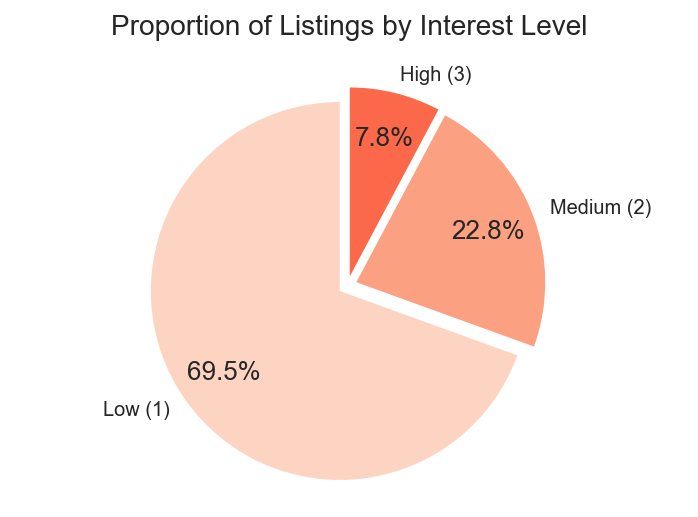

In [45]:
ax = plot_interest_pie(df.interest_level, textprops=dict(fontsize=13), pctdistance=.75)
ax.set_title(ax.get_title(), fontdict=dict(fontsize=14))

# plt.savefig(''.join([REPORT_IMG_DIR, '1-interest-pie.png']), dpi=600)
plt.show()


## Price

__Distribution__

count            inf
mean       3291.2812
std           1.5416
min          43.0000
25%        2500.0000
50%        3150.0000
75%        4100.0000
max     4490000.0000
Name: price_lg, dtype: float64

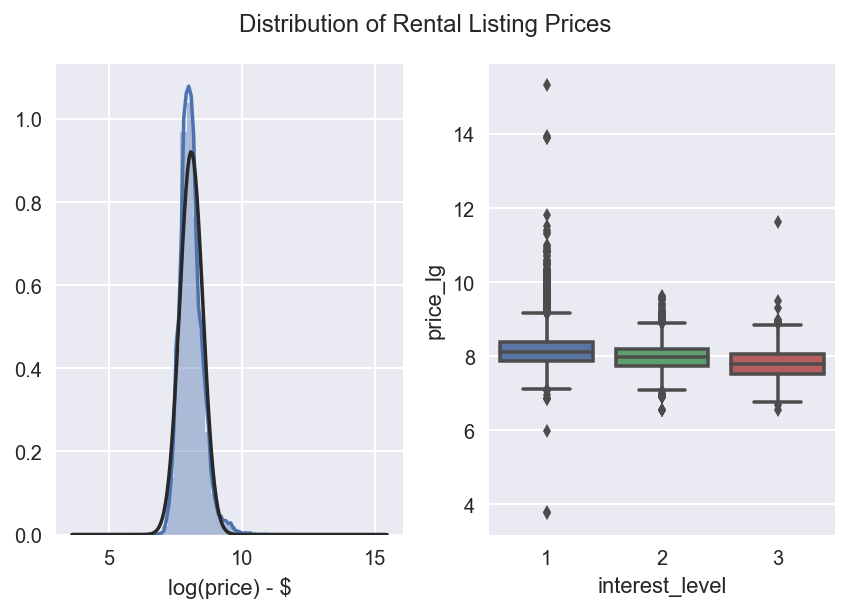

In [46]:
data = df.assign(price_lg=np.log(df.price))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4))
sns.distplot(data.price_lg, fit=stats.norm, ax=ax1)
ax1.set_xlabel('log(price) - $')

sns.boxplot(y='price_lg', x='interest_level', data=data, ax=ax2)
plt.suptitle('Distribution of Rental Listing Prices', y=1.05)

plt.tight_layout()

# Std not accurate given transformations
display(data.price_lg.describe().apply(np.exp))

__Missing__

In [47]:
df.price.sort_values().head(10)

listing_id
7060255     43
6813772     45
6871682    401
6865783    695
6852585    695
6831246    695
6859573    695
7127753    700
6934177    800
6952911    868
Name: price, dtype: int64

Can consider 43 and 45 vals as missing values

__Missing Data and Outliers__

In [48]:
k = 3
price_outls = df[is_price_outl(df.price, k=k)].price

n_outl = len(price_outls)
print('{} ({:.2%}) outliers found with Tukey test with k={}'
      .format(n_outl, n_outl/len(df), k))
display(price_outls.sort_values().head())
display(price_outls.sort_values().tail())

1223 (2.48%) outliers found with Tukey test with k=3


listing_id
7212135    8915
6963542    8925
6992474    8950
6887809    8950
6933522    8985
Name: price, dtype: int64

listing_id
6857401     135000
7036279    1070000
7013217    1070000
7208794    1150000
7208764    4490000
Name: price, dtype: int64

__Relevance__

'P( price_lg | interest_level )'

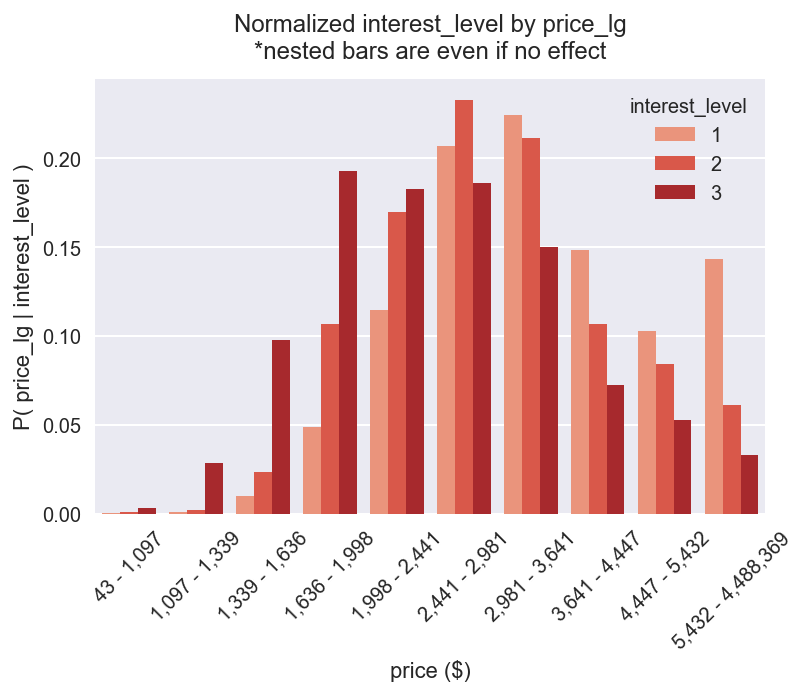

In [61]:
data = df.assign(price_lg=np.log(df.price))

bins = [data.price_lg.min(), 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6,
        data.price_lg.max()]
cond_prob = ConditionalProbabilities(
    x='price_lg', data=data, cond='interest_level', bins=bins
)
ax = cond_prob.plot()

xtickslables = []
for lbl in ax.get_xticklabels():
    lo, hi = re.findall(r'[0-9.]+', lbl.get_text())
    lo, hi = np.exp(float(lo)), np.exp(float(hi))
    xtickslables.append('{:,.0f} - {:,.0f}'.format(lo, hi))
ax.set_xticklabels(xtickslables, rotation=45)
ax.set_xlabel('price ($)')

# plt.savefig(''.join([REPORT_IMG_DIR, '2-price-on-interest.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

## Bedrooms and Bathrooms

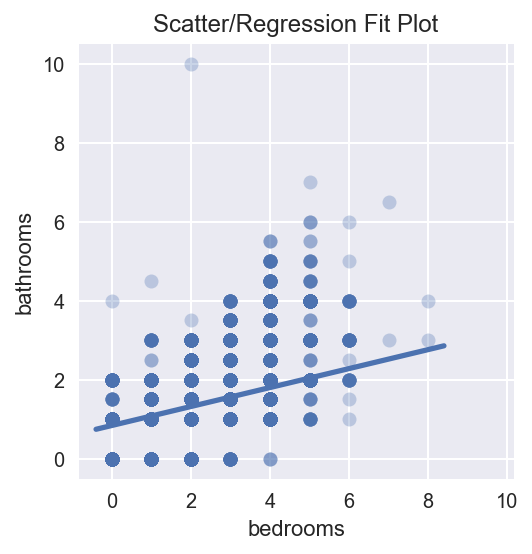

In [28]:
ax = sns.regplot(x='bedrooms', y='bathrooms', data=df,
                 scatter_kws=dict(alpha=.3))
ax.axis('square')
ax.set_title('Scatter/Regression Fit Plot')

# plt.savefig(''.join([REPORT_IMG_DIR, '4-bed-bath-scatter.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

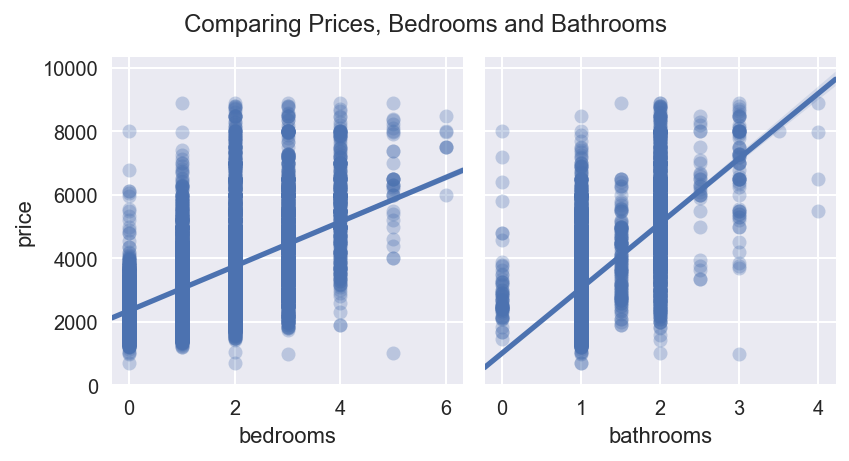

In [29]:
data = df[['bedrooms', 'bathrooms', 'price']]
data = drop_price_outl(data, k=3, msg=False)  # for plotting
data = data.sample(frac=.2, random_state=SEED)  # for performance

sns.pairplot(
    data=data,
    x_vars=['bedrooms', 'bathrooms'],
    y_vars=['price'],
    kind='reg',
    size=3,
    plot_kws=dict(scatter_kws=dict(alpha=.3)),
)
plt.suptitle('Comparing Prices, Bedrooms and Bathrooms', y=1.05)
plt.tight_layout()

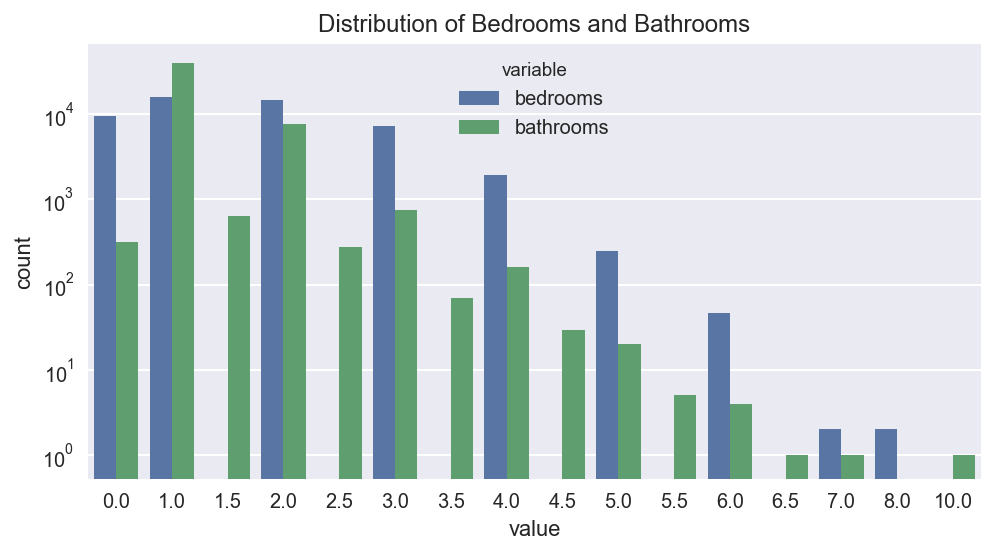

In [58]:
data = pd.melt(df, value_vars=['bedrooms', 'bathrooms'])
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='value', hue='variable', data=data, log=True)
ax.set_title('Distribution of Bedrooms and Bathrooms')

plt.show()

In [ ]:
def set_bedbath_groups(df):
    df = df.assign(group='reasonable')  # default

    no_bed = df.bedrooms == 0
    studio = no_bed & (data.bathrooms==1)
    bath_gt_bed = (df.bathrooms>df.bedrooms) & ~studio
    df.loc[bath_gt_bed, 'group'] = 'bath > bed, except studio'

    no_bath = data.bathrooms == 0
    bed_gt_3bath = (df.bedrooms > df.bathrooms*3) & ~no_bath
    df.loc[bed_gt_3bath, 'group'] = 'bed > bath*3'

    only_bath_missing = ~no_bed & no_bath
    df.loc[only_bath_missing, 'group'] = 'only bathroom missing'

    all_missing = no_bath & no_bed
    df.loc[all_missing, 'group'] = 'both missing'
    
    return df

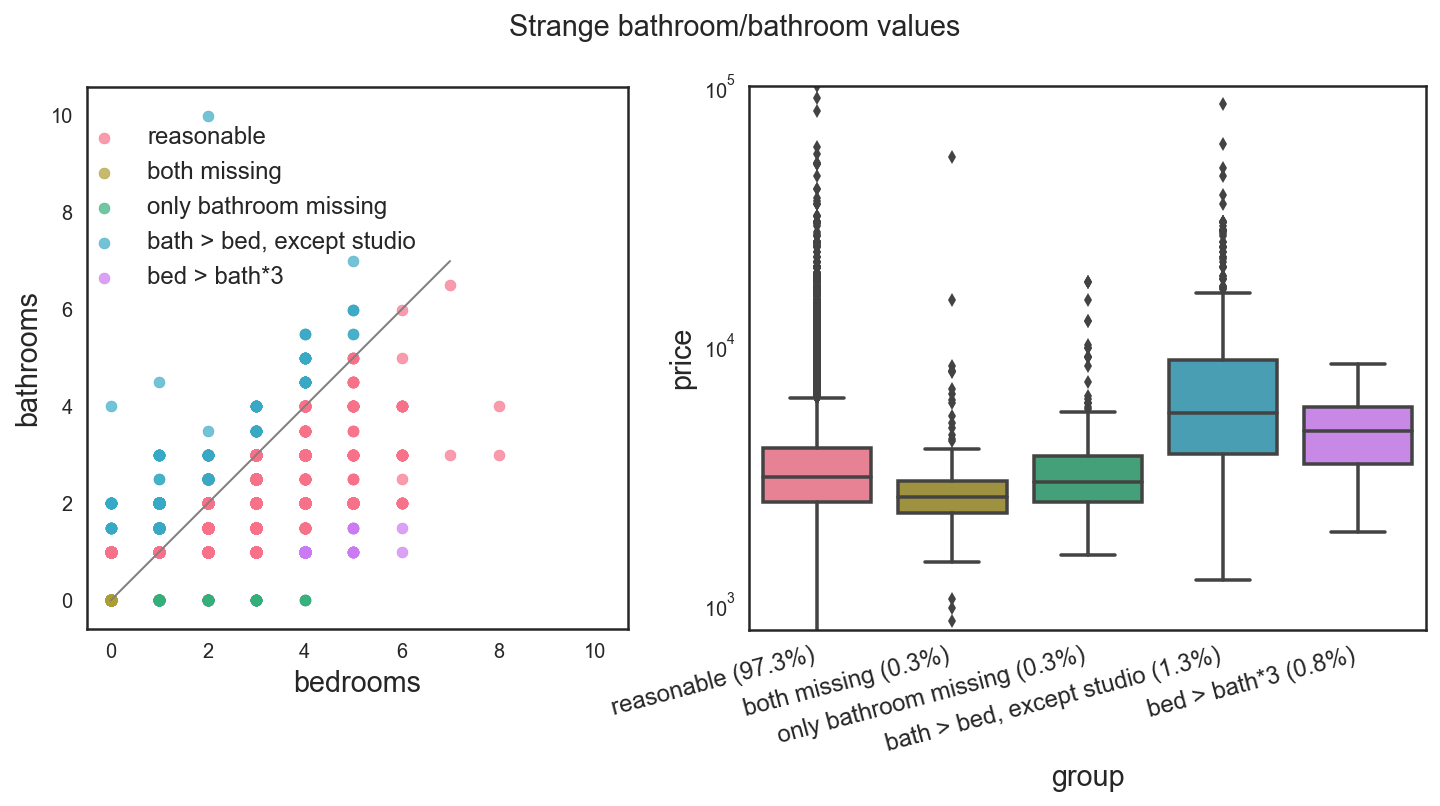

*** Group Counts ***


reasonable                   48023
bath > bed, except studio      634
bed > bath*3                   382
both missing                   157
only bathroom missing          156
Name: group, dtype: int64


*** Median Price by Group ***


group
bath > bed, except studio   5500.0000
bed > bath*3                4695.0000
both missing                2595.0000
only bathroom missing       2982.4906
reasonable                  3105.0000
Name: price, dtype: float64

In [63]:
data = set_bedbath_groups(df)

with sns.axes_style('white'):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5),
                                   gridspec_kw=dict(width_ratios=[4, 5]))

    grouped = data.groupby('group')
    
    group_order = ['reasonable', 'both missing', 'only bathroom missing',
                   'bath > bed, except studio', 'bed > bath*3']
    
    group_colors = sns.color_palette('husl', 5).as_hex()
    for color, name in zip(group_colors, group_order):
        group = grouped.get_group(name)
        group.plot(kind='scatter', x='bedrooms', y='bathrooms', label=name,
                   ax=ax1, color=color, s=30, alpha=.7)
    ax1.plot([0,7], [0,7], 'gray', linewidth=1)
    ax1.axis('square')
    ax1.legend(loc=(-.03, .61), fontsize='large')
    ax1.set_xlabel(ax1.get_xlabel(), fontsize='x-large')
    ax1.set_ylabel(ax1.get_ylabel(), fontsize='x-large')

    sns.boxplot(y='price', x='group', data=data,
                order=group_order, palette=group_colors, ax=ax2)

    xticklabels = []
    cnts = data.group.value_counts(normalize=True)
    for t in ax2.get_xticklabels():
        lbl = t.get_text()
        s = '{} ({:.1%})'.format(lbl, cnts[lbl])
        xticklabels.append(s)

    ax2.set_xticklabels(xticklabels, fontsize='large',
                        rotation=15, ha='right')
    ax2.set_xlabel(ax2.get_xlabel(), fontsize='x-large')
    ax2.set_ylabel(ax2.get_ylabel(), fontsize='x-large')
    
    ax2.set_yscale('log')
    ax2.set_ylim(800, 1e5)

    fig.suptitle('Strange bathroom/bathroom values', fontsize='x-large',
                 y=.98)

#     plt.savefig(''.join([REPORT_IMG_DIR, '3-strange-bed-bath.png']),
#                 dpi=600, bbox_inches='tight')
    plt.show()
    
print('*** Group Counts ***')
display(data.group.value_counts())
print()
print('*** Median Price by Group ***')
display(data.groupby('group')['price']
            .apply(lambda x: np.exp(np.median(np.log(x)))))

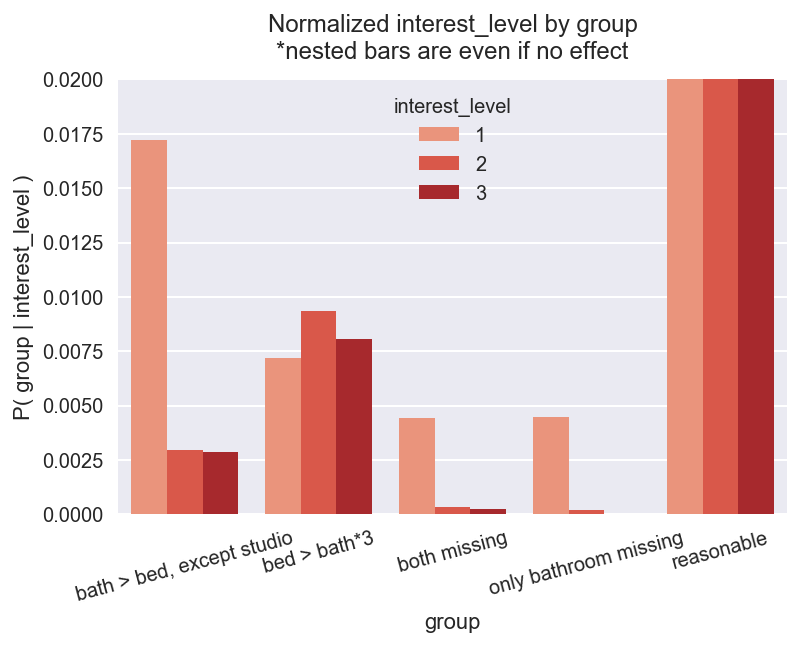

In [64]:
data = set_bedbath_groups(df)

cond_prob = ConditionalProbabilities(
    x='group', data=data, cond='interest_level'
)
ax = cond_prob.plot()
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt.ylim(0, .02)
plt.show()

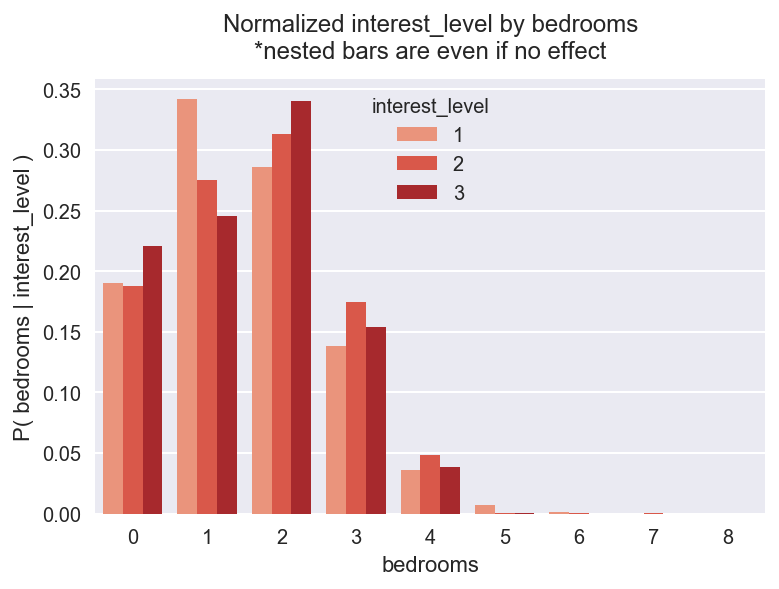

In [65]:
cond_prob = ConditionalProbabilities(
    x='bedrooms', data=df, cond='interest_level'
)
cond_prob.plot()

## Geo-coordinates

In [35]:
df = read_rental_interest(DF_TRAIN_PKL)

Dropped 68 geo-coordinate outliers (0.14%)


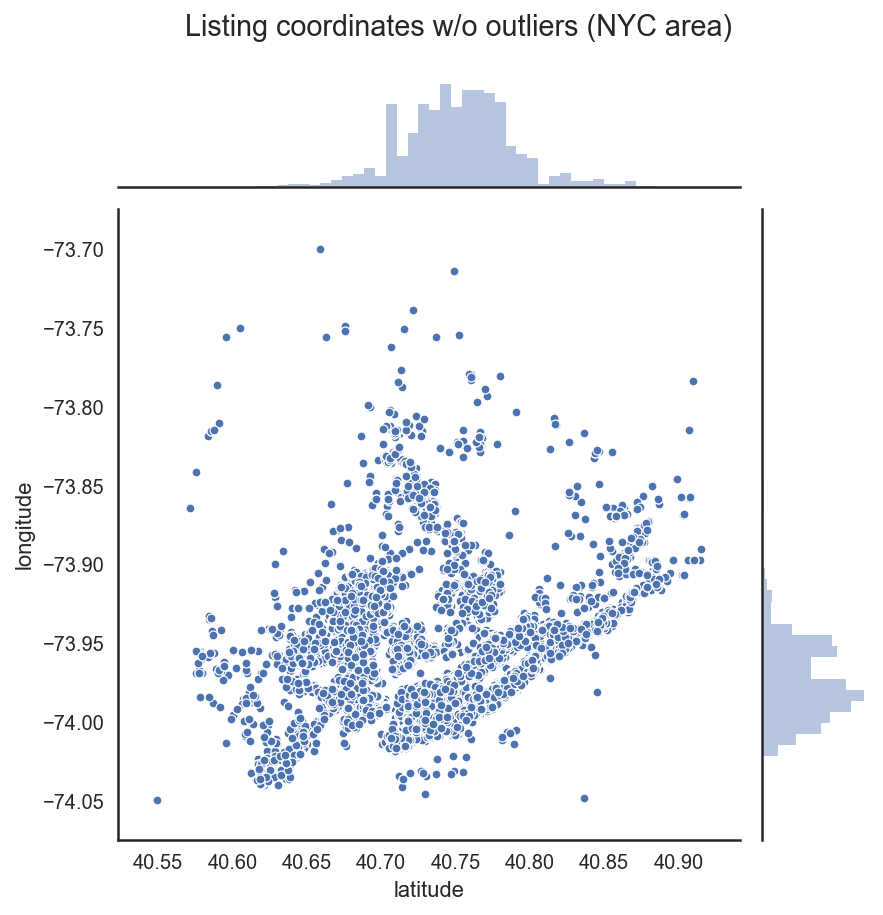

In [37]:
data = drop_geo_outl(df)
with sns.axes_style('white'):
    sns.jointplot('latitude', 'longitude', data=data, stat_func=None,
                  joint_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.suptitle('Listing coordinates w/o outliers (NYC area)', y=1.05,
             fontsize='x-large')
# plt.savefig(''.join([REPORT_IMG_DIR, '5a-geo-coordinates.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

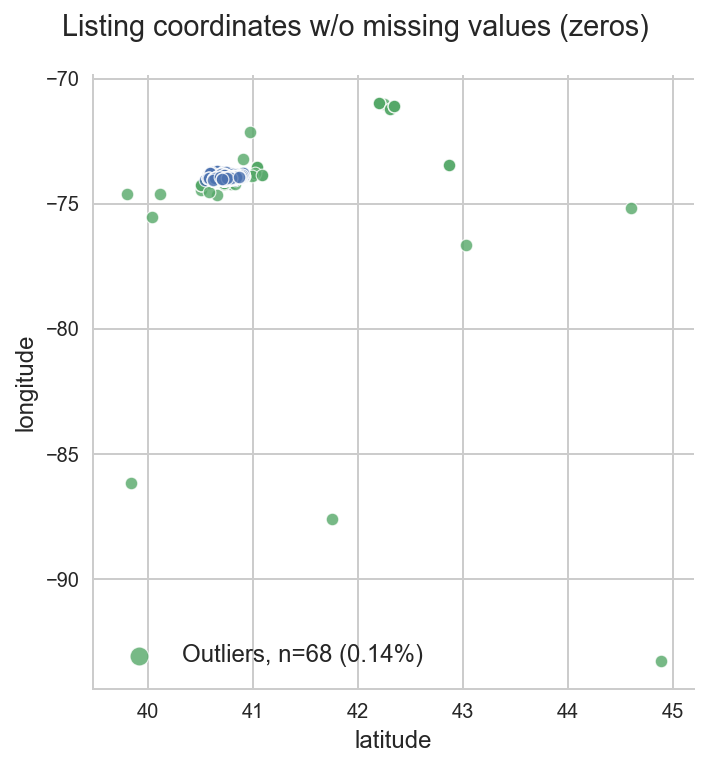

In [38]:
# invert colors so hue that needs to be plotted on top matches
# color of other coordinate scatter plot without outliers
with sns.axes_style('whitegrid'):
    with sns.color_palette(palette=sns.color_palette(palette='deep')[-5::-1]):
        
        # drop missing and one extreme outlier that distorts plot
        data = (df.query('latitude != 0 and longitude != 0')
                  .query('latitude != 34.01260 and longitude != -118.27100')
        )
        # indicate remaining outliers
        # empty string for column removes legend title
        data = data.assign(is_outlier=is_geo_outl(data.latitude, data.longitude))

        sns.lmplot(
            x='latitude', y='longitude', data=data, hue='is_outlier',
            fit_reg=False, hue_order=[True, False],
            legend_out=False, scatter_kws=dict(edgecolor='w', lw=.6, s=40),
        )
        plt.xlabel('latitude', fontsize='large')
        plt.ylabel('longitude', fontsize='large')
        
        plt.legend(['Outliers, n=68 (0.14%)'], loc='lower left',
                   markerscale=1.5, title=False, fontsize='large')
        plt.suptitle('Listing coordinates w/o missing values (zeros)',
                     fontsize='x-large', y=1.05)
#         plt.savefig(''.join([REPORT_IMG_DIR, '5b-geo-coordinates.png']),
#                     dpi=600, bbox_inches='tight')
        plt.show()


Rounding geo-coordinates:
- Latitude
    - "Each degree of latitude is approximately 69 miles (111 kilometers) apart."
    - 5 ft = 0.00094697 miles = 0.000013724 degrees
    - 
- Longitude
    - "At 40° north or south, the distance between a degree of longitude is 53 miles (85 kilometers)."
    - 5 ft = 0.00094697 miles = 0.000017867 degrees


Source: https://www.thoughtco.com/degree-of-latitude-and-longitude-distance-4070616

## Dates

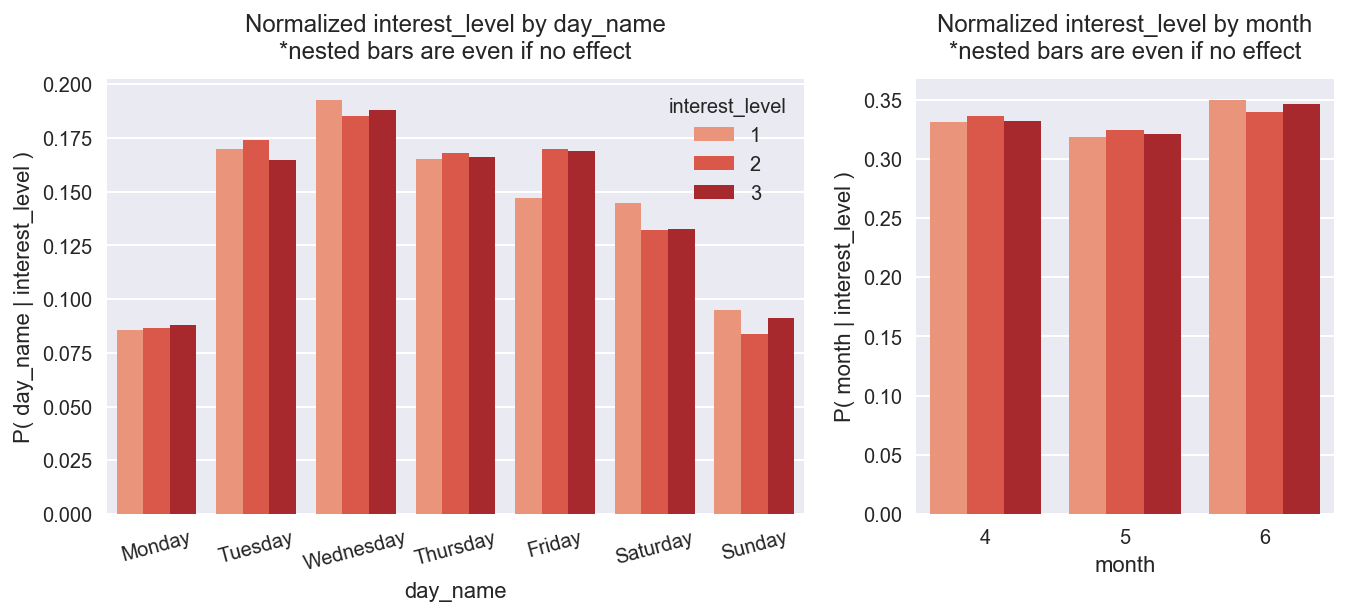

In [66]:
df['month']    = df.created.map(lambda x: x.month).astype(int)
df['day']      = df.created.map(lambda x: x.day).astype(int)
df['day_name'] = df.created.dt.weekday_name

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4),
                               gridspec_kw=dict(width_ratios=[5, 3]))

cond_prob1 = ConditionalProbabilities(
    x='day_name', data=df, cond='interest_level'
)
cond_prob1.plot(order=day_order, ax=ax1)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

cond_prob2 = ConditionalProbabilities(
    x='month', data=df, cond='interest_level'
)
cond_prob2.plot(ax=ax2)

ax2.legend('')

# plt.savefig(''.join([REPORT_IMG_DIR, '6-dates-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

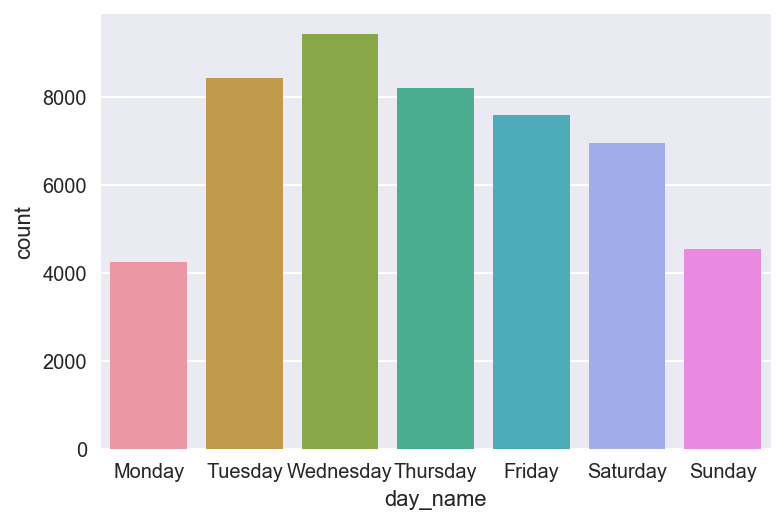

In [45]:
sns.countplot(x='day_name', data=df, order=day_order)

['21.783%', '19.870%', '18.716%', '17.122%', '12.093%', '10.417%', '0.000%']


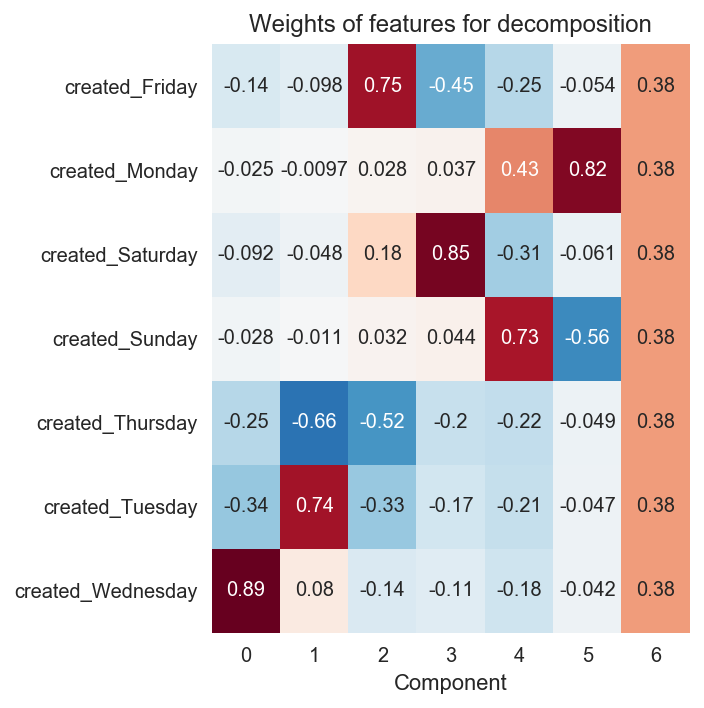

In [120]:
reducer = PCA()

reduced = reducer.fit_transform(days)
explained_variance = reducer.explained_variance_ratio_
print(['{:.3%}'.format(x) for x in explained_variance])

plt.figure(figsize=(5, 5))
sns.heatmap(reducer.components_.T, yticklabels=days.columns.tolist(),
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

## Addresses

In [48]:
df = read_rental_interest(DF_TRAIN_PKL)

How many missing display addresses have street addresses?

In [49]:
df[(df.street_address!='') & (df.display_address=='')].shape

(126, 14)

How many missing display addresses?

In [50]:
df[df.display_address==''].shape

(135, 14)

In [51]:
print('{} unique display addresses'.format(len(df.display_address.unique())))

8826 unique display addresses


In [52]:
df.display_address.value_counts().head()

Broadway            438
East 34th Street    355
Second Avenue       349
Wall Street         332
West 37th Street    287
Name: display_address, dtype: int64

How many listings have the same display address but different coordinates?

In [53]:
addr_cnts = df.groupby('display_address').apply(
    lambda x: len(x.latitude.unique()))

print((addr_cnts>1).sum())
display(addr_cnts.sort_values(ascending=False).head())

1951


display_address
                    117
Broadway             67
Second Avenue        63
First Avenue         56
Lexington Avenue     40
dtype: int64

## Number of Photos

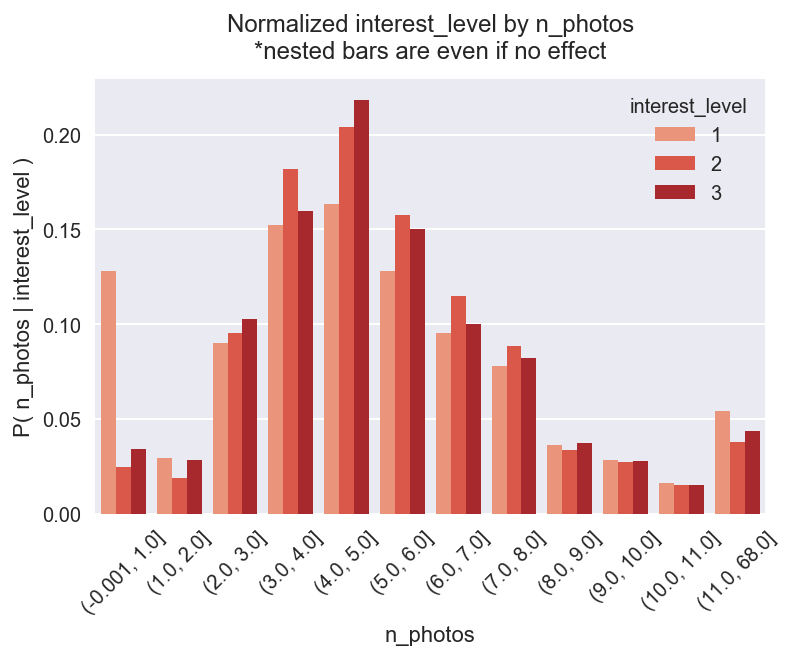

In [77]:
# do number of photos affect interest?
data = df.assign(n_photos=df.photos.map(lambda x: len(x)))

bins = list(range(0, 12)) + [data['n_photos'].max()]
cond_prob = ConditionalProbabilities(
    x='n_photos', data=data, cond='interest_level', bins=bins
)
ax = cond_prob.plot()

plt.xticks(rotation=45)

plt.savefig(''.join([REPORT_IMG_DIR, '7-n-photos-on-interest.png']),
            dpi=600, bbox_inches='tight')

plt.show()

## Number of Features

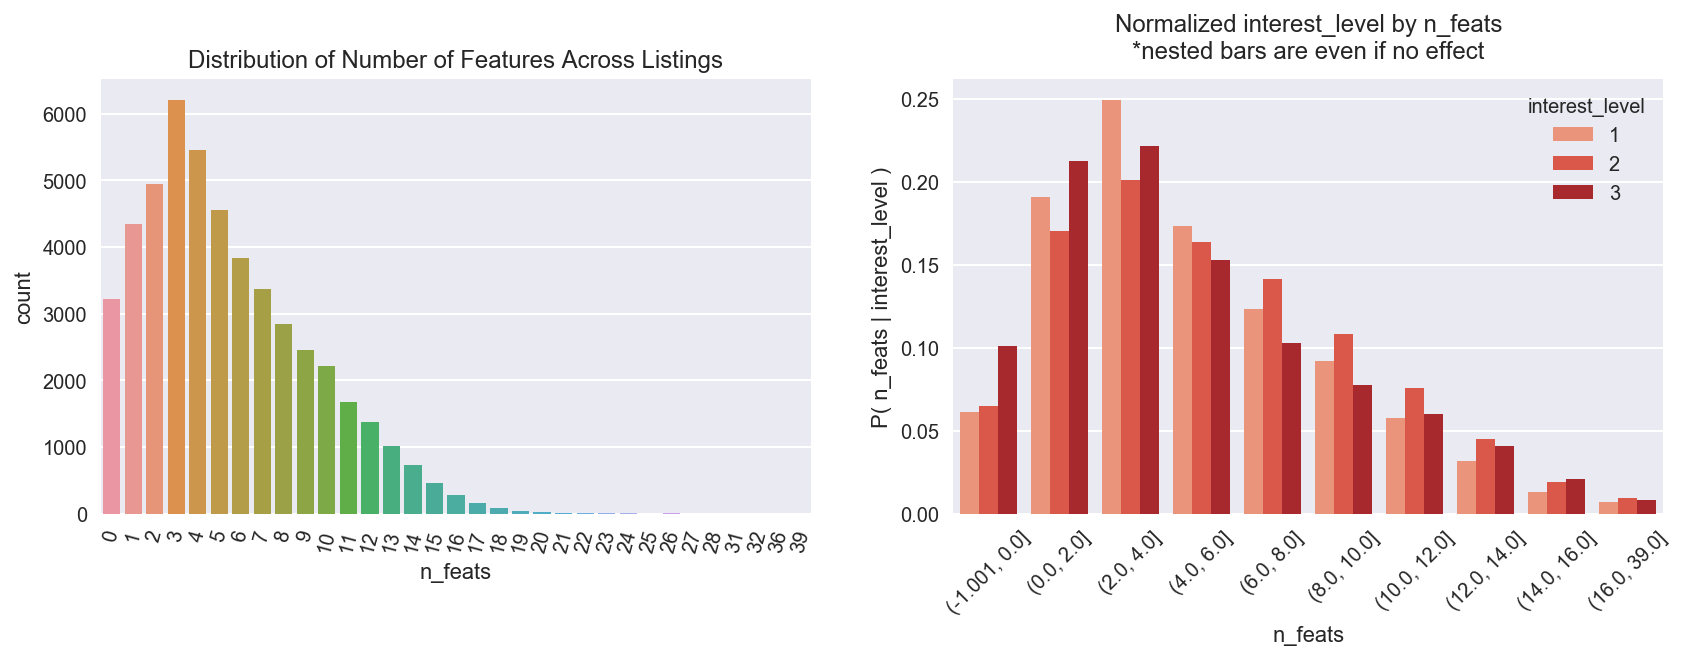

In [88]:
# do number of features affect interest?
data = df.assign(n_feats=df.features.apply(lambda x: len(x)))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

ax1.set_title('Distribution of Number of Features Across Listings')
sns.countplot(data.n_feats, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=75)

bins = [-1] + list(range(0, 17, 2)) + [data['n_feats'].max()]
cond_prob = ConditionalProbabilities(
    x='n_feats', data=data, cond='interest_level', bins=bins
)
cond_prob.plot(ax=ax2)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# plt.savefig(''.join([REPORT_IMG_DIR, '8-n-feats-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Description Word Count

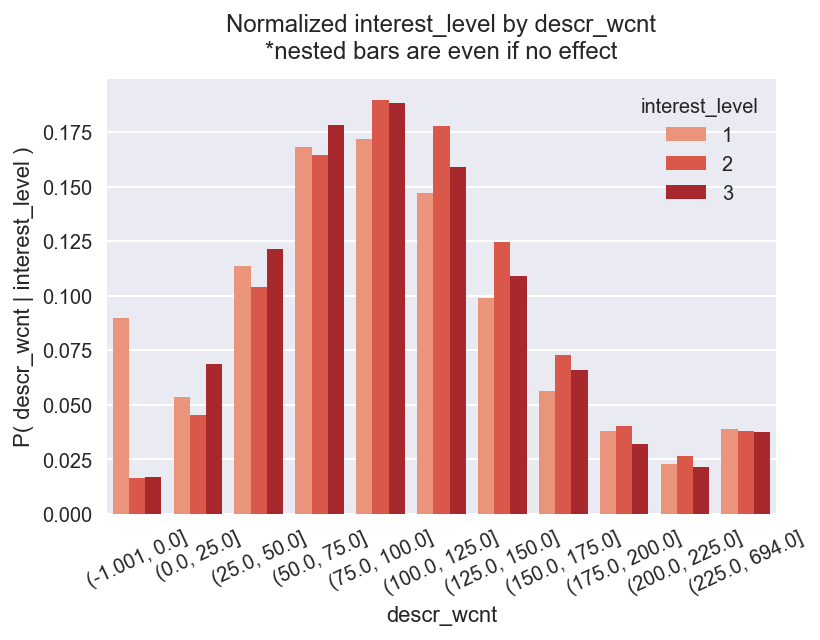

In [89]:
# does length of description affect interest?
data = df.assign(descr_wcnt=df.description.apply(get_word_cnt))

bins = [-1] + list(range(0, 226, 25)) + [data.descr_wcnt.max()]
cond_prob = ConditionalProbabilities(
    x='descr_wcnt', data=data, cond='interest_level', bins=bins
)
cond_prob.plot()

plt.xticks(rotation=25)

plt.savefig(''.join([REPORT_IMG_DIR, '9-descrip-wcnt-on-interest.png']),
            dpi=600, bbox_inches='tight')

plt.show()

## Manager Activity and Performance

- Total posts
- Posts/duration
- Rating/post

chi2 p-val = 0.0000 (rounded)


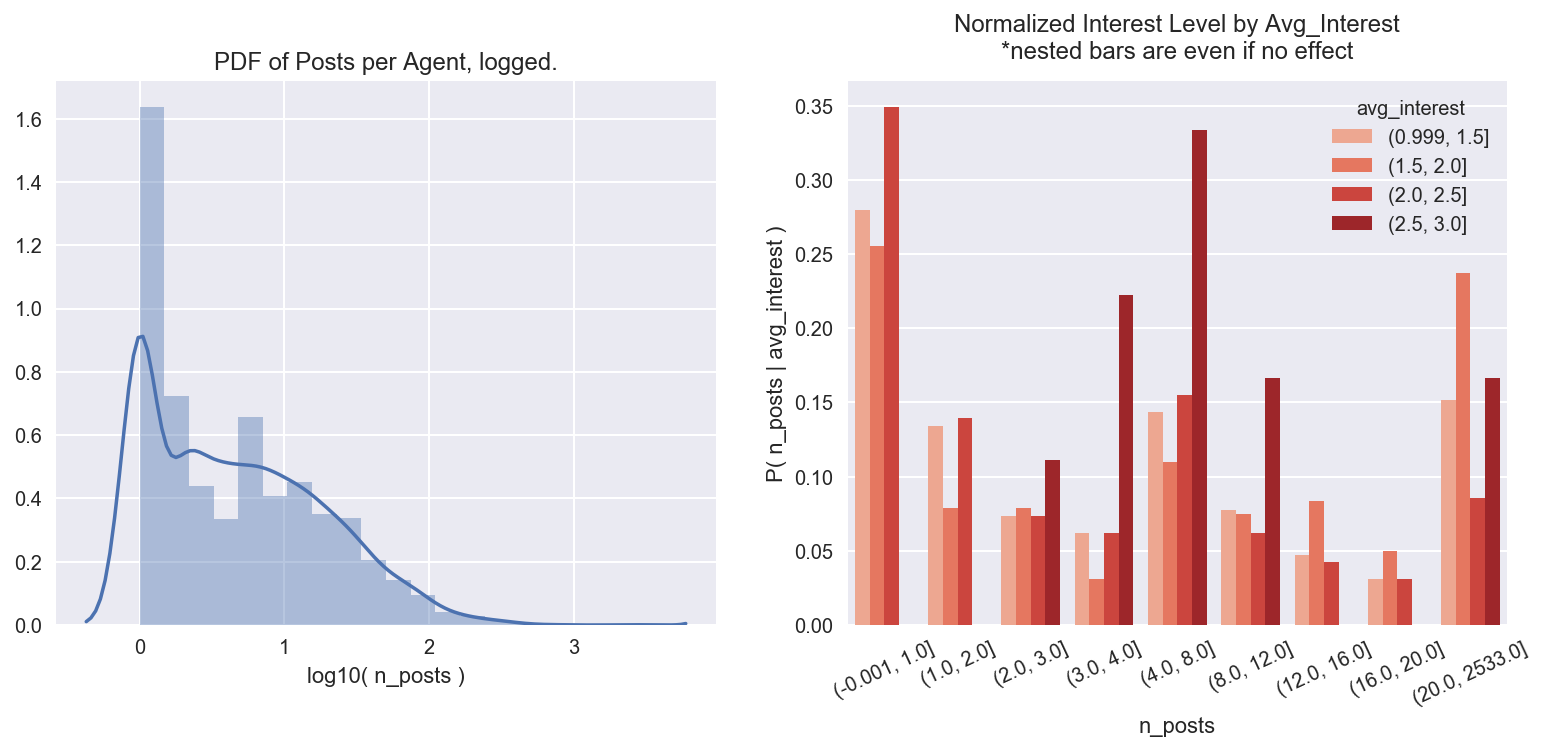

In [97]:
# see if activity of agents affects interest

prior = df.interest_level.mean()
avg_int = (df.groupby('manager_id')['interest_level']
           .apply(exp_int, prior)
#            .mean()
           .rename('avg_interest')
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
n_posts = df.manager_id.value_counts().rename('n_posts')

ax1 = sns.distplot(np.log10(n_posts), bins=20, ax=ax1)

ax1.set_xlabel('log10( n_posts )')
ax1.set_title('PDF of Posts per Agent, logged.')

data = pd.concat([n_posts, avg_int], axis=1)

bins = [0, 1, 2, 3] + list(range(4, 24, 4)) + [data.n_posts.max()]
cond_bins = [1, 1.5, 2, 2.5, 3]
cond_prob = ConditionalProbabilities(
    x='n_posts', data=data, cond='avg_interest', bins=bins,
    cond_bins=cond_bins
)
cond_prob.plot(ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)
ax2.legend(loc='upper right', title='avg_interest')

# plt.savefig(''.join([REPORT_IMG_DIR, '10-n-posts-on-avg-interest.png']),
#             dpi=600, bbox_inches='tight')
plt.show()